<a href="https://colab.research.google.com/github/LeeJaeEun0/PlayData_Minproject_230127/blob/main/mask_230127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim # 최적화 알고리즘 구현
from torch.optim import lr_scheduler # 학습률 lr을 구현
import numpy as np
import torchvision # datasets, models, transforms으로 구성
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time # 시간 관련 모듈
import os # 운영체제
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil # 폴더 복사
import time # 시간 관련 계산
import copy # 파일 복사

In [ ]:
!git clone https://github.com/prajnasb/observations # git에서 코랩으로 바로 파일 다운로드

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 18.09 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (3045/3045), done.


In [ ]:
!ls observations/experiements/dest_folder/

test  test.csv	train  train.csv  val


## Creating image datasets an data loaders for train and test using the experiments folder split

In [ ]:
experiments_path = 'observations/experiements/dest_folder/' # train, test 나눠진 데이터, 우리가 사용
data_path = 'observations/experiements/data/' # train, test 나누기 전에 사용

https://pytorch.org/vision/stable/transforms.html#compositions-of-transforms

In [ ]:
data_transforms ={  # 딕셔너리 형태로 train, test 만들기
    'train': transforms.Compose([ # transforms를 통해 전처리 및 정규화를 위해서 사용
        transforms.RandomResizedCrop(224), # 이미지의 임의 부분을 잘라내고 지정된 크기로 조정 => 224인 정사각형, 종류가 다양해야 학습이 잘됨
        transforms.ToTensor(), # PIM image나 numpy.ndarray를 텐서로 바꿈
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 평균과 표준편차로 텐서 이미지를 정규화 
    ]), 
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),# resize하고 가운데를 중심으로 자르기(크기 맞춤) 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 컬러값은 거의 고정, 흑백으로 할 경우 변할 수 있음
    ])
}


In [ ]:
# 파일 복사 및 폴더 생성 부분 생략

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

In [ ]:
# list_ = ['train','test']
# image_datasets = {} # 딕셔너리 형태로 만듦

# for x in list_:
#   # datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) # image_datasets에 저장 안함
#   image_datasets[x] = datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) # train과 test의 내용(객체)를 넣음

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
  for x in ['train','test']}


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# dataloaders = {}
# for x in list_: # 배치 사이즈 = 한번에 데이터를 비교하는 수
#   dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True)

In [ ]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fca82a23040>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fca82a23070>}

In [ ]:
class_names = image_datasets['train'].classes

In [ ]:
class_names

['with_mask', 'without_mask']

In [ ]:
# gpu, cpu 사용 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [ ]:
dataset_sizes

{'train': 1315, 'test': 194}

In [ ]:
# dataset_sizes ={}

# for x in ['train','test']:
#   dataset_sizes[x] = len(image_datasets[x])

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  #matplotlib에서는 numpy로만 데이터를 받아서 , numpy 배열로 넣을때 순서 변경 - 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # 0,1보다 크거나 작으면 0,1로 바꾸고, 사이 값은 그대로
    plt.figure(figsize=(20,20)) # 출력 사이즈
    plt.imshow(inp) # 이미지 출력

    if title is not None: # 파일명이 있으면 출력
        plt.title(title)
    plt.pause(0.001)
    

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

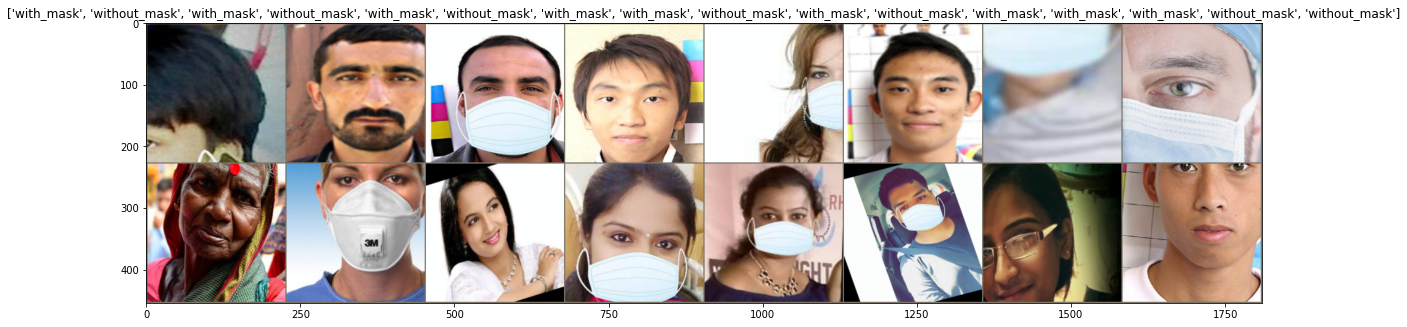

In [ ]:
imshow(out, title=[class_names[x] for x in classes]) # 이미지 출력

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time() # 시간
    best_acc = 0.0 # 정확도
    best_model = copy.deepcopy(model.state_dict()) # 각 계층을 매개변수 텐서로 매핑!
    
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1)) # 0- 19까지 20개
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0 # 손실
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()  # 가중치 초기화
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # 
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)# 손실율
                    
                    if phase == 'train':
                        loss.backward() # 역전파
                        optimizer.step() # 가중치 최적화
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model
                

In [ ]:
import ssl

In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context

* Restnet101은 101개의 계층으로 구성된 컨벌루션 신경망
사전에 훈련된 신경망의 훈련버전 불러 올 수 있음
신경망의 영상 입력 크기는 244 x 244

In [ ]:
model_ft = models.resnet101(pretrained=True) # 만들어진 모델을 가져와서 사용

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss() # 손실함수

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001) # 최적화 함수 - 최적의 조합 찾기
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) # 학습률을 감소?

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.2044 Acc:0.9072

test Loss: 0.0498 Acc:0.9794

Epoch 1/19
----------
train Loss: 0.0952 Acc:0.9605

test Loss: 0.0112 Acc:0.9948

Epoch 2/19
----------
train Loss: 0.0869 Acc:0.9574

test Loss: 0.1157 Acc:0.9794

Epoch 3/19
----------
train Loss: 0.1168 Acc:0.9559

test Loss: 0.0559 Acc:0.9794

Epoch 4/19
----------
train Loss: 0.0817 Acc:0.9574

test Loss: 0.0007 Acc:1.0000

Epoch 5/19
----------
train Loss: 0.0789 Acc:0.9589

test Loss: 0.0006 Acc:1.0000

Epoch 6/19
----------
train Loss: 0.0782 Acc:0.9574

test Loss: 0.0002 Acc:1.0000

Epoch 7/19
----------
train Loss: 0.0644 Acc:0.9749

test Loss: 0.0002 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.0570 Acc:0.9673

test Loss: 0.0002 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.0679 Acc:0.9650

test Loss: 0.0003 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.0708 Acc:0.9597

test Loss: 0.0002 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0546 Acc:0.9711

test Loss: 0.0002 Acc:1.0000

Epoch 12/19
----------
t

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure(figsize=(10,10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds,"predicitons")
            
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                #ax = plt.subplot(num_images//len(labels)-1, len(labels), images_so_far)
                #ax.axis('off')
                #ax.set_title('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                print('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                #imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
!cd /content/drive/MyDrive/mask

In [ ]:
torch.save(model_ft, '/content/drive/MyDrive/mask/mask1_model_resnet101.pth')

In [ ]:
visualize_model(model_ft)

tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0') predicitons
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: with_mask predicted: with_mask
